# Stochastic Differential Equations: Lab 1

In [1]:
from IPython.core.display import HTML
css_file = 'https://raw.githubusercontent.com/ngcm/training-public/master/ipython_notebook_styles/ngcmstyle.css'
HTML(url=css_file)

This background for these exercises is article of D Higham, [*An Algorithmic Introduction to Numerical Simulation of Stochastic Differential Equations*, SIAM Review 43:525-546 (2001)](http://epubs.siam.org/doi/abs/10.1137/S0036144500378302).
Higham provides Matlab codes illustrating the basic ideas at <http://personal.strath.ac.uk/d.j.higham/algfiles.html>, which are also given in the paper.

For random processes in `python` you should look at the `numpy.random` module. To set the initial seed (which you should *not* do in a real simulation, but allows for reproducible testing), see `numpy.random.seed`.

## Brownian processes

Simulate a Brownian process over $[0, 1]$ using a step length $\delta t = 1/N$ for $N = 500, 1000, 2000$. Use a fixed seed of `100`. Compare the results.

In [12]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
rcParams['figure.figsize'] = (12,6)
from scipy.integrate import quad

Evaluate the function $u(W(t)) = \sin^2(t + W(t))$, where $W(t)$ is a Brownian process, on $M$ Brownian paths for $M = 500, 1000, 2000$. Compare the *average* path for each $M$.

Analytic solution to integral is

$$
\begin{equation}
  \int_{-\infty}^{\infty} \frac{\sin(t+x)^2 \exp(-x^2 / 2t)}{\sqrt{2 \pi t}} dx
\end{equation}
$$

In [2]:
#This computes the exact solution!

tint = numpy.linspace(0.005, numpy.pi, 1000)
def integrand(x,t):
    return numpy.sin(t+x)**2*numpy.exp(-x**2/(2.0*t))/numpy.sqrt(2.0*numpy.pi*t)
intexact = numpy.zeros_like(tint)
for i, t in enumerate(tint):
    intexact[i], err = quad(integrand, -numpy.inf, numpy.inf, args=(t,))

In [35]:
def W(trange, dw=None):
    N = len(trange)
    tst = np.array(np.random.rand(2)*N, dtype=int)
    
    assert type(trange) == np.ndarray, "Ensure 'trange' is a numpy array"
    #assert abs(trange[tst[0]] - trange[tst[0]-1] - trange[tst[1]] + trange[tst[1]-1])<1e-6,\
    #        "'trange' must be a numpy array of equally spaced points"
    assert len(trange) > 2, "'trange' must contain more than 1 element"
    
    if dw == None:
        #np.random.seed(100)
        dw = (-0.5+np.random.rand(N-1))*np.sqrt(trange[1]-trange[0])
    else:
        assert (len(trange)-1) == len(dw), "'dw' must be one element shorter than trange"
    return np.append([0.0], np.cumsum(dw))

0.00500197238811
0.0235257153825
0.00237166991822


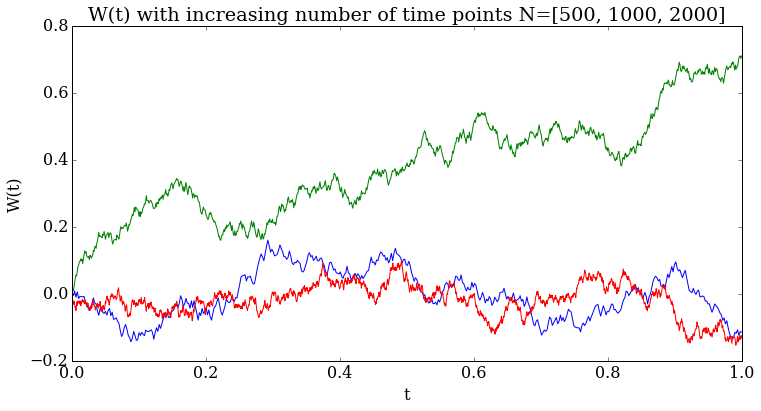

In [40]:
for N in [500, 1000, 2000]:
    trange = np.linspace(0, 1, N)
    w=W(trange)
    plt.plot(trange, w)
    print(np.var(w))
    
plt.xlabel("t")
plt.ylabel("W(t)")
plt.title("W(t) with increasing number of time points N=[500, 1000, 2000]")

In [41]:
def U(h, t):
    return np.sin(t + h(t))**2

3
3
3


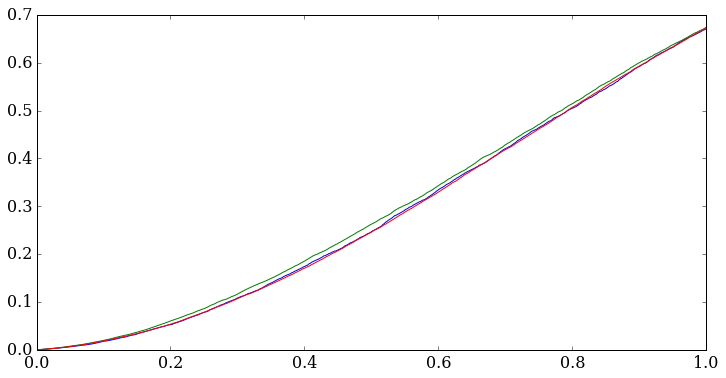

In [47]:
trange = np.linspace(0, 1, 500)
u_avg = np.zeros((3, len(trange)))
for i, M in enumerate([500, 1000, 2000]):
    u = np.zeros((M, len(trange)))
    for j in np.arange(M):
        u[j] = U(W, trange)
    u_avg[i] = np.mean(u, axis=0)
    print(len(u_avg))
    plt.plot(trange, u_avg[i])


## Stochastic integrals

Write functions to compute the Itô and Stratonovich integrals of a function $h(t, W(t))$ of a *given* Brownian process $W(t)$ over the interval $[0, 1]$.

In [17]:
def ito(h, trange, dw=None, seed=100):
    """Compute the Ito stochastic integral given the range of t.
    
    Parameters
    ----------
    
    h : function
        integrand
    trange : list of float
        the range of integration
    dW : array of float
        Brownian increments
    seed : integer
        optional seed for the Brownian path
    Returns
    -------
    
    ito : float
        the integral
    """
    np.random.seed(seed=seed)
    N = len(trange)
    if dw==None:
        dw = (np.random.rand(N-1) - 0.5)*np.sqrt(1/float(N))
    ito = np.sum(h(trange, dw)[:-1]*dw)
    return ito

In [18]:
def stratonovich(h, trange, dw=None, seed=100):
    """Compute the Stratonovich stochastic integral given the range of t.
    
    Parameters
    ----------
    
    h : function
        integrand
    trange : vector of float
        the range of integration
    dW : array of float
        the Brownian increments
        
    Returns
    -------
    
    stratonovich : float
        the integral
    """
    np.random.seed(seed=seed)
    N = len(trange)
    if dw==None:
        dw = (np.random.rand(N-2) - 0.5)*np.sqrt(1/float(N))
    tavg = (trange[:-1] + trange[1:])/2.0
    stratonovich = np.sum(h(tavg, dw)[:-1]*dw)
    return stratonovich

Test the functions on $h = W(t)$ for various $N$. Compare the limiting values of the integrals.

## Euler-Maruyama's method

Apply the Euler-Maruyama method to the stochastic differential equation

$$
\begin{equation}
  dX(t) = \lambda X(t) + \mu X(t) dW(t), \qquad X(0) = X_0.
\end{equation}
$$

Choose any reasonable values of the free parameters $\lambda, \mu, X_0$.

The exact solution to this equation is $X(t) = X(0) \exp \left[ \left( \lambda - \tfrac{1}{2} \mu^2 \right) t + \mu W(t) \right]$. Fix the timetstep and compare your solution to the exact solution.

In [54]:
def euler_maruyama(trange, l=3.0, mu=1.0, X0=1.0, R=2, dw=None, seed=100):
    """Compute the Stratonovich stochastic integral given the range of t.
    
    Parameters
    ----------
    
    h : function
        integrand
    trange : vector of float
        the range of integration
    dW : array of float
        the Brownian increments
        
    Returns
    -------
    
    em : float
        the integral
    """
    N = len(trange)
    R = int(R)
    DT = R * (trange[1] - trange[0])
    L = int(N/R)
    np.random.seed(seed=seed)
    if dw==None:
        dw = (np.random.rand(N-2) - 0.5)*np.sqrt(1/float(N))
    xt = X0
    em = np.zeros(L)
    for i in np.arange(L):
        Winc = np.sum(dw[R * (i-1) + 1 : R * i])
        xt = xt + l*DT*xt + mu*xt*Winc
        em[i] = xt
    T = np.linspace(trange[0], trange[-1], L)
    true = X0 * np.exp((l - 1/2 * mu**2) * trange + mu*W(trange))
    return T, em, true

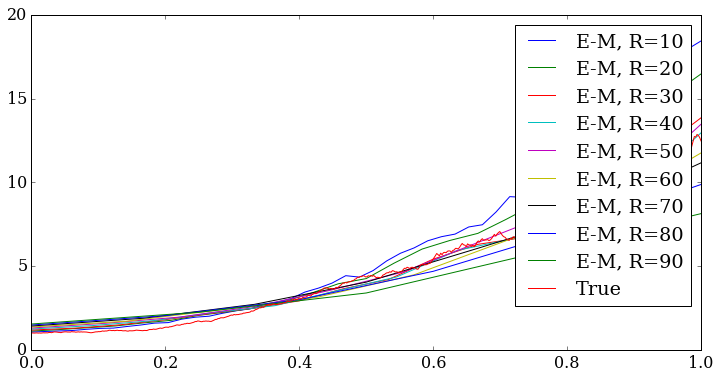

In [62]:
for r in np.arange(10, 100, 10):
    t, em, x_true = euler_maruyama(trange, R=r)
    plt.plot(t, em, label="E-M, R={}".format(r))
plt.plot(trange, x_true, label="True")
plt.legend()

Vary the timestep of the Brownian path and check how the numerical solution compares to the exact solution.

## Convergence

Investigate the weak and strong convergence of your method, applied to the problem above.

## Milstein's method

Implement Milstein's method, applied to the problem above.

Check the convergence again.

Compare the *performance* of the Euler-Maruyama and Milstein method using eg `timeit`. At what point is one method better than the other?

## Population problem

Apply the algorithms, convergence and performance tests to the SDE

$$
\begin{equation}
  dX(t) = r X(t) (K - X(t)) dt + \beta X(t) dW(t), \qquad X(0) = X_0.
\end{equation}
$$

Use the parameters $r = 2, K = 1, \beta = 0.25, X_0 = 0.5$.

Investigate how the behaviour varies as you change the parameters $r, K, \beta$.